In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from math import pi 
from scipy import special

In [2]:
def generate_data(N_train = 2 ** 12, N_test = 2 ** 14): 
    
    def f(x):
        a = 1 / 100
        si, ci = special.sici(x / a)
        return si * np.exp(-x ** 2 / 2)

    x_train = np.random.normal(0, 1, N_train)
    x_train = np.reshape(x_train, (N_train, 1))
    y_train = f(x_train)
    
    x_validation = np.random.normal(0, 1, N_train)
    x_validation = np.reshape(x_validation, (N_train, 1))
    y_validation = f(x_validation)
    
    x_test = np.linspace(-25 * pi, 25 * pi, N_test).reshape(N_test, 1)
    x_test = np.reshape(x_test, (N_test, 1))
    y_test = f(x_test)
    
    return x_train, y_train, x_validation, y_validation, x_test, y_test

In [3]:
# compute cut-off frequency w0

def method_1_w0(x, y, px): 
    
    # calculate f_p
    dx = x[1] - x[0]
    E_y = np.sum(px * y * dx)
    fp = np.sqrt(px) * (y - E_y)

    # fast Fourier transform
    N = len(x)
    yf = np.fft.fft(fp, axis=0)
    
    # the minimization function 
    dw = 2*pi/N/dx 
    K = np.linspace(-N/2, N/2-1, N)
    f2 = np.abs(yf * dx)**2 * dw

    # compute the difference 
    var_f = np.sum(f2)
    n0 = range(0, int(N/2))
    e_diff = np.zeros(int(N/2))
    
    for k in n0:
        if k>=0 and k<=N/2-1: 
            if k==0: 
                e_low = f2[k]
                e_high = var_f - e_low
            else:
                e_low = f2[0] + 2*np.sum(f2[1:k])
                e_high = var_f - e_low
            e_diff[k] = np.abs(e_low-e_high)
        else: 
            print("index error")
    
    # calculate the cut-off w0
    e_diff_min = min(e_diff)
    w0 = np.argmin(e_diff) 
    
    return w0, var_f

In [4]:
def method_1(var_f, w0, x_test, y_test, pred, px): 
    
    N = len(x_test) 
    # compute r
    r = y_test - pred

    # calculate r_p
    dx = x_test[1] - x_test[0]
    r_mean = np.sum(px * r * dx)
    rp = np.sqrt(px) * (r - r_mean) 

    # Fourier transform 
    rf = np.fft.fft(rp, axis=0)
    rf = np.reshape(rf, (N, 1))

    # compute sum_low
    dw = 2*pi/N/dx 
    r2 = np.abs(rf * dx)**2 * dw
    w0 = int(w0)
    if w0==0: 
        e_low_sum = r2[w0]
        e_high_sum = sum(r2) - e_low_sum
    else:
        e_low_sum = r2[0] + 2*np.sum(r2[1:w0])
        e_high_sum = sum(r2) - e_low_sum

    # compute SB
    e_low = e_low_sum/var_f
    e_high = e_high_sum/var_f
    
    SB = (e_high - e_low) / (e_high + e_low)
    
    return SB

In [5]:
def FVU_compute(y, pred): 
    r = y - pred 
    var_r = np.var(r)
    var_f = np.var(y)
    FVU = var_r/var_f 
    return FVU 

In [6]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

In [7]:
tf.keras.backend.set_floatx('float64')

input_dim=1
output_dim=1
num_layers=5
num_nodes=64

activation=tf.keras.activations.relu
kernel_initializer=tf.keras.initializers.he_normal
bias_initializer=tf.keras.initializers.Zeros()
# Define the network. This class corresponds to an MLP.
# input layer
inputs = tf.keras.Input(shape=(input_dim,), name="Input")

# Hidden Layers
x = Dense(units=num_nodes, activation=activation, kernel_initializer=kernel_initializer,
                  bias_initializer=bias_initializer)(inputs)
for i in np.arange(1, num_layers):
    x = Dense(units=num_nodes, activation=activation, kernel_initializer=kernel_initializer,
                      bias_initializer=bias_initializer)(x)
# Outputs
outputs = Dense(output_dim, activation="linear", name="predictions")(x)
if output_dim == 3:
    outputs = Dense(output_dim, activation="linear", name="predictions")(x)

# Compile the model
model = Model(inputs=inputs, outputs=outputs)

In [8]:
# implement experiment 2

N_train = 2 ** 12
N_test = 2 ** 14

seed = 1
np.random.seed(seed)

x_train, y_train, x_validation, y_validation, x_test, y_test = generate_data()

# Save training values for training error evaluation
x_train_eval = x_train
y_train_eval = y_train

# Normalize the training data
x_mean = x_train.mean(axis=0)
x_std = x_train.std(axis=0)
y_mean = y_train.mean(axis=0)
y_std = y_train.std(axis=0)
x_train = (x_train - x_mean) / x_std
y_train = (y_train - y_mean) / y_std

px = 1 / x_std / np.sqrt(2 * np.pi) * np.exp(-1 / 2 * (((x_test) / x_std) ** 2))
px_train = 1 / x_std / np.sqrt(2 * np.pi) * np.exp(-1 / 2 * ((x_train / x_std) ** 2))
px_validation = 1 / x_std / np.sqrt(2 * np.pi) * np.exp(-1 / 2 * ((x_validation / x_std) ** 2))

w0, var = method_1_w0(x_test, y_test, px)
print(w0)

57


In [9]:
class Compute_SB_Callback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):

        # Print the training loss for every tenth epoch
        if epoch % 10 == 0:
            print("\nEnd of epoch  " + str(epoch) + ", Training error " +
                      str(np.mean((y_train_eval - nn_predict(x_train_eval)) ** 2))) 
            
        i = int(epoch - 1)
                      
        pred = nn_predict(x_train_eval)
        pred_validation = nn_predict(x_validation)
        FVU[i] = FVU_compute(y_train, pred)
        FVU_validation[i] = FVU_compute(y_validation, pred_validation)
    
        w0, var = method_1_w0(x_test, y_test, px)
        pred_test = nn_predict(x_test)
        SB_ = method_1(var, w0, x_test, y_test, pred_test, px)
        SB_M1[i] = SB_
        
        #print(SB)

In [10]:
batch_size = 32
epochs = 1000
num_evals=100
mod = int(epochs / num_evals)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1).batch(batch_size)

loss_fn = tf.keras.losses.mean_squared_error
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

def nn_predict(x):
    x = (x - x_mean) / x_std
    beta = model(x) * y_std + y_mean
    return beta.numpy()

FVU = np.zeros(epochs)
FVU_validation = np.zeros(epochs)
SB_M1 = np.zeros(epochs)

SB_callback = Compute_SB_Callback()
tf.random.set_seed(seed)
model.compile(optimizer=optimizer, loss=loss_fn)
beta = model.fit(x_train, y_train, epochs=epochs, batch_size=32, callbacks=[SB_callback])

my_loss = beta.history['loss']


End of epoch  0, Training error 4.084885931509151
Epoch 1/1000
128/128 [==============================] - 0s 921us/step - loss: 0.7136
Epoch 2/1000
128/128 [==============================] - 0s 916us/step - loss: 0.5749
Epoch 3/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.4707
Epoch 4/1000
128/128 [==============================] - 0s 965us/step - loss: 0.3597
Epoch 5/1000
128/128 [==============================] - 0s 935us/step - loss: 0.2552
Epoch 6/1000
128/128 [==============================] - 0s 927us/step - loss: 0.1730
Epoch 7/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.1187
Epoch 8/1000
128/128 [==============================] - 0s 921us/step - loss: 0.0845
Epoch 9/1000
128/128 [==============================] - 0s 902us/step - loss: 0.0652
Epoch 10/1000
128/128 [==============================] - 0s 960us/step - loss: 0.0535

End of epoch  10, Training error 0.06891539205230385
Epoch 11/1000
128/128 [=========================

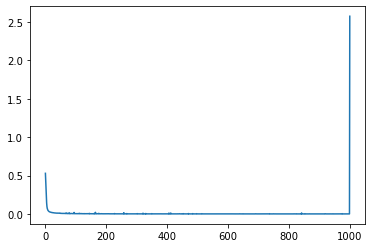

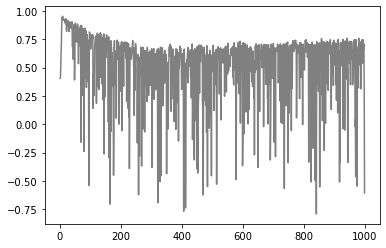

In [11]:
t_vec = np.arange(0, epochs)
plt.plot(t_vec[1:], FVU_validation[1:])
plt.show()

plt.plot(t_vec[1:], SB_M1[1:], color='0.5', label="Method 1")
plt.show()